   Release Year                            Title Origin/Ethnicity  \
0          1907  How Brown Saw the Baseball Game         American   
1          1907                     Laughing Gas         American   
2          1908         The Adventures of Dollie         American   
3          1908                  The Black Viper         American   
4          1908           A Calamitous Elopement         American   

               Director                               Cast   Genre  \
0               Unknown                            Unknown  comedy   
1  Edwin Stanton Porter    Bertha Regustus, Edward Boulden  comedy   
2        D. W. Griffith  Arthur V. Johnson, Linda Arvidson   drama   
3        D. W. Griffith                     D. W. Griffith   drama   
4         D.W. Griffith       Harry Solter, Linda Arvidson  comedy   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/How_Brown_Saw_th...   
1  https://en.wikipedia.org/wiki/Laughing_Gas_(fi...

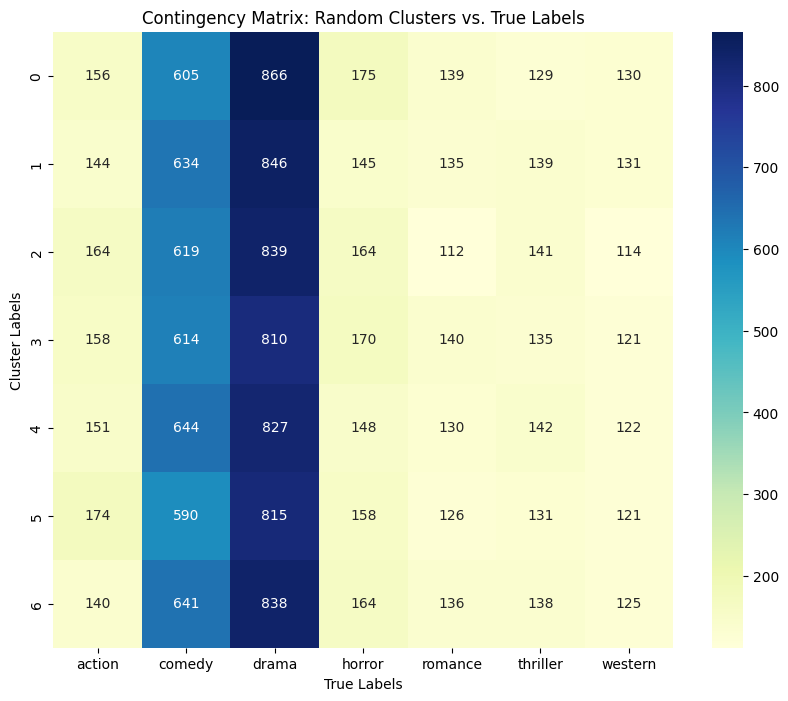

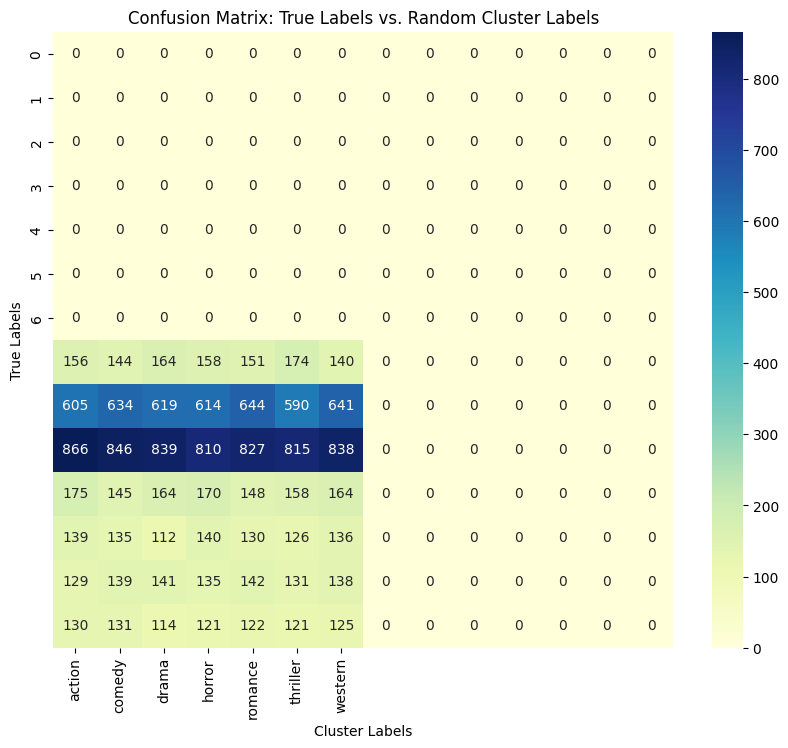

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Encode 'Origin/Ethnicity' and 'Genre'
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])

# Tokenize 'Title' and 'Cast' for Word2Vec
data['Title_Tokens'] = data['Title'].fillna('').apply(lambda x: x.split())
data['Cast_Tokens'] = data['Cast'].fillna('').apply(lambda x: x.split(','))

# Train Word2Vec for 'Title' and 'Cast'
title_w2v_model = Word2Vec(sentences=data['Title_Tokens'], vector_size=100, window=3, min_count=1, workers=4)
cast_w2v_model = Word2Vec(sentences=data['Cast_Tokens'], vector_size=100, window=3, min_count=1, workers=4)

# Function to get Word2Vec embeddings
def get_w2v_embedding(tokens, model, vector_size):
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

# Generate embeddings for 'Title' and 'Cast'
data['Title_Embedding'] = data['Title_Tokens'].apply(lambda x: get_w2v_embedding(x, title_w2v_model, 100))
data['Cast_Embedding'] = data['Cast_Tokens'].apply(lambda x: get_w2v_embedding(x, cast_w2v_model, 100))

# Expand embedding columns into separate features
title_embeddings = np.vstack(data['Title_Embedding'].values)
cast_embeddings = np.vstack(data['Cast_Embedding'].values)

# Drop non-numeric columns (keeping embeddings)
data = data.drop(columns=['Title', 'Cast', 'Wiki Page', 'Plot', 'Title_Tokens', 'Cast_Tokens'])

# Combine all features
numeric_features = data[['Release Year', 'Origin/Ethnicity']].values
combined_features = np.hstack((numeric_features, title_embeddings, cast_embeddings))

# Standardize all features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_features)

# Generate random cluster labels
true_labels = data['Genre']
random_cluster_labels = np.random.randint(0, len(np.unique(true_labels)), size=len(true_labels))

# Compute Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
ari_random = adjusted_rand_score(true_labels, random_cluster_labels)
nmi_random = normalized_mutual_info_score(true_labels, random_cluster_labels)

print(f"Random Clustering ARI: {ari_random:.4f}")
print(f"Random Clustering NMI: {nmi_random:.4f}")

# Generate the confusion matrix for random clustering vs. true labels
contingency_matrix = pd.crosstab(random_cluster_labels, true_labels)

# Create a heatmap to visualize the contingency matrix
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Contingency Matrix: Random Clusters vs. True Labels")
plt.xlabel("True Labels")
plt.ylabel("Cluster Labels")
plt.show()

# Ensure true_labels and random_cluster_labels have the same data type
true_labels = true_labels.astype(str)
random_cluster_labels = random_cluster_labels.astype(str)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, random_cluster_labels)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=np.unique(true_labels),
    yticklabels=np.unique(random_cluster_labels),
    cbar=True
)
plt.title("Confusion Matrix: True Labels vs. Random Cluster Labels")
plt.xlabel("Cluster Labels")
plt.ylabel("True Labels")
plt.show()